# 🧬 Stanford RNA 3D Folding Competition: Structure Prediction Masterclass 🧠

<a href="https://www.kaggle.com/competitions/stanford-ribonanza-rna-folding" target="_blank">
  <img src="https://img.shields.io/badge/Kaggle-Competition-blue?style=for-the-badge&logo=kaggle" alt="Kaggle Competition">
</a>

🌟 **Welcome to the Ultimate RNA 3D Structure Prediction Notebook!** 🌟

*Unlock the secrets of RNA folding through graph deep learning. This comprehensive guide combines biological insights with advanced AI techniques to tackle one of molecular biology's most challenging problems.*

---

## 🚀 Notebook Roadmap: From Sequence to Structure

<div style="padding: 15px; border: 2px solid #2ecc71; border-radius: 10px; margin: 20px 0;">
🔍 **Section 1: Exploratory Data Analysis (EDA)**  
   - 📌 3D coordinate distribution analysis  
   - 📌 Sequence pattern visualization  
   - 📌 Structural thermodynamics insights
</div>

<div style="padding: 15px; border: 2px solid #3498db; border-radius: 10px; margin: 20px 0;">
🔧 **Section 2: Data Preprocessing Pipeline**  
   - 🧬 RNA sequence encoding  
   - 🎯 Coordinate normalization & outlier detection  
   - 🧩 Dynamic padding for variable-length sequences
</div>

<div style="padding: 15px; border: 2px solid #9b59b6; border-radius: 10px; margin: 20px 0;">
🤖 <strong>Section 3: Graph Neural Network Architecture</strong>  
</div>

<div style="padding: 15px; border: 2px solid #e67e22; border-radius: 10px; margin: 20px 0;">
⚙️ <strong>Section 4: Model Training Strategies</strong><br>  
🎯 Loss: Weighted MAE + Structural Consistency<br>  
⏱️ Early stopping with 3D validation<br>  
🔄 Gradient clipping (norm=1.0)  
</div>


## 1. Data  Loading and Exploration

In [1]:
pip install --upgrade pip


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 23.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
Note: you may need to restart the kernel to use updated packages.


In [1]:
!pip install spektral

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 3.0 MB/s eta 0:00:00a 0:00:01


In [2]:
pip install --upgrade spektral


Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow/Keras for deep learning model
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
#For GCN MODEL
from spektral.layers import GCNConv

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


We load the CSV files provided in the competition:
- `train_sequences.csv`
- `train_labels.csv`
- `validation_sequences.csv` & `validation_labels.csv`
- `test_sequences.csv`
- `sample_submission.csv`



In [4]:
TRAIN_SEQ_PATH = '/kaggle/input/stanford-rna-3d-folding/train_sequences.csv'
TRAIN_LABELS_PATH = '/kaggle/input/stanford-rna-3d-folding/train_labels.csv'
VALID_SEQ_PATH = '/kaggle/input/stanford-rna-3d-folding/validation_sequences.csv'
VALID_LABELS_PATH = '/kaggle/input/stanford-rna-3d-folding/validation_labels.csv'
TEST_SEQ_PATH  = '/kaggle/input/stanford-rna-3d-folding/test_sequences.csv'
SAMPLE_SUB_PATH = '/kaggle/input/stanford-rna-3d-folding/sample_submission.csv'

train_sequences = pd.read_csv(TRAIN_SEQ_PATH)
train_labels = pd.read_csv(TRAIN_LABELS_PATH)
valid_sequences = pd.read_csv(VALID_SEQ_PATH)
valid_labels = pd.read_csv(VALID_LABELS_PATH)
test_sequences = pd.read_csv(TEST_SEQ_PATH)
sample_submission = pd.read_csv(SAMPLE_SUB_PATH)

train_labels.fillna(0, inplace=True)
valid_labels.fillna(0, inplace=True)

print("Train Sequences Shape:", train_sequences.shape)
print("Train Labels Shape:", train_labels.shape)
print("Validation Sequences Shape:", valid_sequences.shape)
print("Validation Labels Shape:", valid_labels.shape)
print("Test Sequences Shape:", test_sequences.shape)

print("\nTrain Sequences Head:")
print(train_sequences.head())
print("\nTrain Labels Head:")
print(train_labels.head())

Train Sequences Shape: (844, 5)
Train Labels Shape: (137095, 6)
Validation Sequences Shape: (12, 5)
Validation Labels Shape: (2515, 123)
Test Sequences Shape: (12, 5)

Train Sequences Head:
  target_id                            sequence temporal_cutoff  \
0    1SCL_A       GGGUGCUCAGUACGAGAGGAACCGCACCC      1995-01-26   
1    1RNK_A  GGCGCAGUGGGCUAGCGCCACUCAAAAGGCCCAU      1995-02-27   
2    1RHT_A            GGGACUGACGAUCACGCAGUCUAU      1995-06-03   
3    1HLX_A                GGGAUAACUUCGGUUGUCCC      1995-09-15   
4    1HMH_E  GGCGACCCUGAUGAGGCCGAAAGGCCGAAACCGU      1995-12-07   

                                         description  \
0               THE SARCIN-RICIN LOOP, A MODULAR RNA   
1  THE STRUCTURE OF AN RNA PSEUDOKNOT THAT CAUSES...   
2  24-MER RNA HAIRPIN COAT PROTEIN BINDING SITE F...   
3  P1 HELIX NUCLEIC ACIDS (DNA/RNA) RIBONUCLEIC ACID   
4  THREE-DIMENSIONAL STRUCTURE OF A HAMMERHEAD RI...   

                                       all_sequences  
0  >1SCL_1|Chai

**histogram of sequence lengths across train, validation, and test sets**
The model pads sequences to a maximum length (4298 in the training set), but understanding the distribution can inform padding strategies or model architecture (e.g., handling variable lengths better).

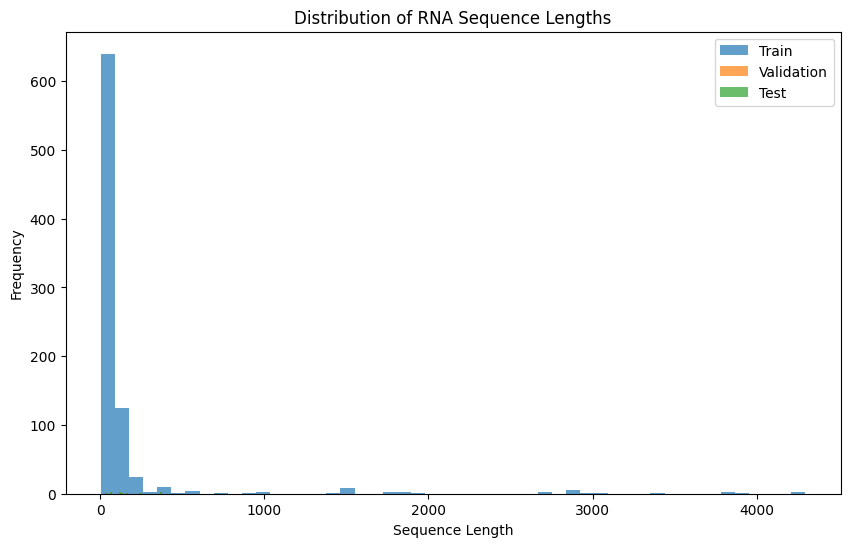

In [5]:
plt.figure(figsize=(10, 6))
plt.hist(train_sequences['sequence'].str.len(), bins=50, alpha=0.7, label='Train')
plt.hist(valid_sequences['sequence'].str.len(), bins=50, alpha=0.7, label='Validation')
plt.hist(test_sequences['sequence'].str.len(), bins=50, alpha=0.7, label='Test')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of RNA Sequence Lengths')
plt.legend()
plt.show()

**Calculating and visualizing the proportion of each nucleotide**

The frequency of A, C, G, and U might influence folding patterns or model bias.


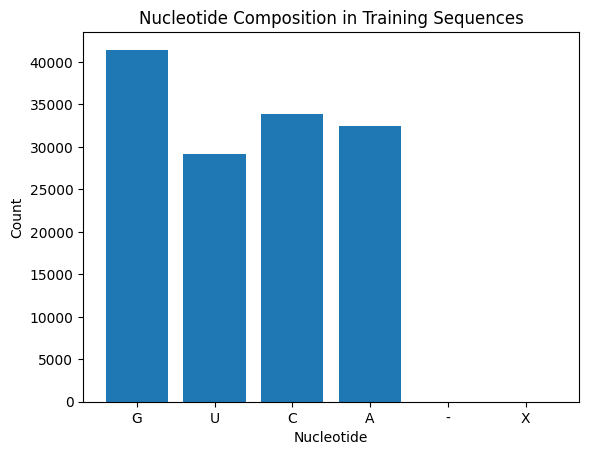

In [6]:
from collections import Counter
train_nucleotides = ''.join(train_sequences['sequence'])
counts = Counter(train_nucleotides)
plt.bar(counts.keys(), counts.values())
plt.title('Nucleotide Composition in Training Sequences')
plt.xlabel('Nucleotide')
plt.ylabel('Count')
plt.show()

**histograms or boxplots of coordinates and compute statistics**

Understanding the range and spread of x, y, z coordinates can help assess data scale and whether normalization is needed.

In [7]:
coords = np.vstack([train_labels_dict[tid] for tid in train_labels_dict])
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, coord in enumerate(['x_1', 'y_1', 'z_1']):
    axes[i].hist(coords[:, i], bins=50)
    axes[i].set_title(f'Distribution of {coord}')
plt.tight_layout()
plt.show()

NameError: name 'train_labels_dict' is not defined

**Convert to datetime and explore trends over time**

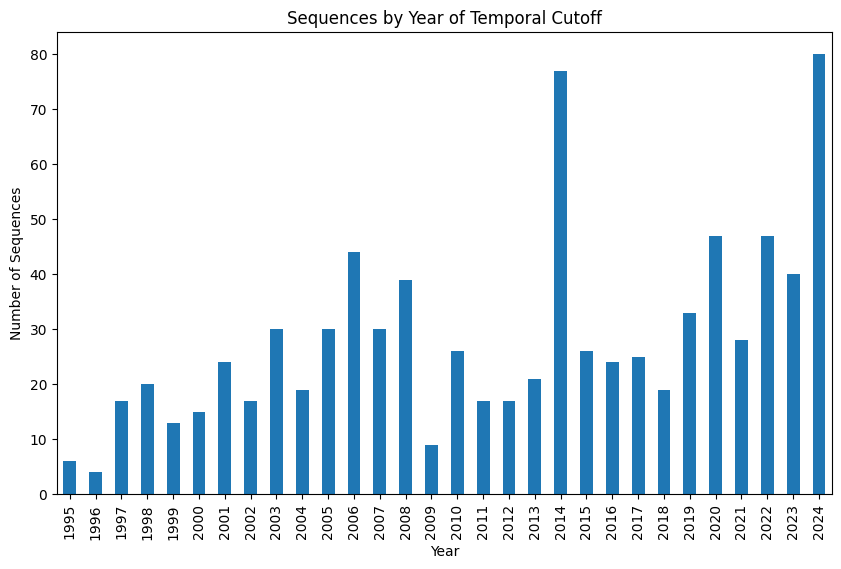

In [8]:
train_sequences['temporal_cutoff'] = pd.to_datetime(train_sequences['temporal_cutoff'])
plt.figure(figsize=(10, 6))
train_sequences['temporal_cutoff'].dt.year.value_counts().sort_index().plot(kind='bar')
plt.title('Sequences by Year of Temporal Cutoff')
plt.xlabel('Year')
plt.ylabel('Number of Sequences')
plt.show()

## 2. Data Preprocessing

### Sequence Encoding

We map each nucleotide to an integer:
- A: 1, C: 2, G: 3, U: 4  
Unknown characters are mapped to 0.

In [9]:
nucleotide_map = {'A': 1, 'C': 2, 'G': 3, 'U': 4}

def encode_sequence(seq):
    """Encodes a RNA sequence into a list of integers based on nucleotide_map."""
    return [nucleotide_map.get(ch, 0) for ch in seq]

# Apply encoding to all sequence files
train_sequences['encoded'] = train_sequences['sequence'].apply(encode_sequence)
valid_sequences['encoded'] = valid_sequences['sequence'].apply(encode_sequence)
test_sequences['encoded'] = test_sequences['sequence'].apply(encode_sequence)

** Processing Label Data**

Each row in the labels CSV is for one residue, with an `ID` formatted as `target_id_resid`.
We group rows by `target_id` and sort by residue number.
Here, we use the first structure (x_1, y_1, z_1) as our target coordinates.

In [10]:
def process_labels(labels_df):
    """
    Processes a labels DataFrame by grouping rows by target_id.
    Returns a dictionary mapping target_id to an array of coordinates (seq_len, 3).
    """
    label_dict = {}
    for idx, row in labels_df.iterrows():
        # Split ID into target_id and residue number (assumes format "targetid_resid")
        parts = row['ID'].split('_')
        target_id = "_".join(parts[:-1])
        resid = int(parts[-1])
        # Extract the coordinates; they should be numeric (missing values already set to 0)
        coord = np.array([row['x_1'], row['y_1'], row['z_1']], dtype=np.float32)
        if target_id not in label_dict:
            label_dict[target_id] = []
        label_dict[target_id].append((resid, coord))
    
    # Sort residues by resid and stack coordinates
    for key in label_dict:
        sorted_coords = sorted(label_dict[key], key=lambda x: x[0])
        coords = np.stack([c for r, c in sorted_coords])
        label_dict[key] = coords
    return label_dict

# Process training and validation labels
train_labels_dict = process_labels(train_labels)
valid_labels_dict = process_labels(valid_labels)

In [11]:
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix

nucleotide_map = {'A': 1, 'C': 2, 'G': 3, 'U': 4}

def encode_sequence(seq):
    return np.array([nucleotide_map.get(ch, 0) for ch in seq], dtype=np.int8)

train_sequences['encoded'] = train_sequences['sequence'].apply(encode_sequence)
valid_sequences['encoded'] = valid_sequences['sequence'].apply(encode_sequence)
test_sequences['encoded'] = test_sequences['sequence'].apply(encode_sequence)

def process_labels(labels_df):
    label_dict = {}
    for idx, row in labels_df.iterrows():
        parts = row['ID'].split('_')
        target_id = "_".join(parts[:-1])
        resid = int(parts[-1])
        coord = np.array([row['x_1'], row['y_1'], row['z_1']], dtype=np.float32)
        if target_id not in label_dict:
            label_dict[target_id] = []
        label_dict[target_id].append((resid, coord))
    for key in label_dict:
        sorted_coords = sorted(label_dict[key], key=lambda x: x[0])
        coords = np.stack([c for r, c in sorted_coords])
        label_dict[key] = coords
    return label_dict

train_labels_dict = process_labels(train_labels)
valid_labels_dict = process_labels(valid_labels)

def create_graph_dataset(sequences_df, labels_dict, max_samples=None, max_len=None):
    X_list, A_list, y_list, target_ids = [], [], [], []
    for idx, row in sequences_df.iterrows():
        tid = row['target_id']
        if tid in labels_dict:
            seq = row['encoded']
            seq_len = min(len(seq), max_len) if max_len else len(seq)  # Cap sequence length
            X = seq[:seq_len].reshape(-1, 1)  # Truncate if needed
            edges = [(i, i+1) for i in range(seq_len-1)] + [(i+1, i) for i in range(seq_len-1)]
            A = np.array(edges, dtype=np.int16).T  # [2, n_edges]
            y = labels_dict[tid][:seq_len]  # Match labels to truncated sequence
            X_list.append(X)
            A_list.append(A)
            y_list.append(y)
            target_ids.append(tid)
            if max_samples and len(X_list) >= max_samples:
                break
    return X_list, A_list, y_list, target_ids

# Set max_len globally and pass it to ensure consistency
max_len = max(min(len(seq), 122) for seq in train_sequences['encoded'])  # Use train max
print("Maximum sequence length (train):", max_len)

X_train, A_train, y_train, train_ids = create_graph_dataset(train_sequences, train_labels_dict, max_samples=100, max_len=max_len)
X_valid, A_valid, y_valid, valid_ids = create_graph_dataset(valid_sequences, valid_labels_dict, max_samples=100, max_len=max_len)

def pad_graph(X, A, y, max_len):
    seq_len = X.shape[0]
    if seq_len < max_len:
        X_pad = np.pad(X, ((0, max_len - seq_len), (0, 0)), mode='constant', constant_values=0)
        A_pad = A.copy()  # Edge list stays as-is
        y_pad = np.pad(y, ((0, max_len - seq_len), (0, 0)), mode='constant', constant_values=0)
    else:
        X_pad, A_pad, y_pad = X, A, y
    return X_pad, A_pad, y_pad

X_train_pad, A_train_pad, y_train_pad = [], [], []
for x, a, y in zip(X_train, A_train, y_train):
    x_p, a_p, y_p = pad_graph(x, a, y, max_len)
    X_train_pad.append(x_p)
    A_train_pad.append(a_p)
    y_train_pad.append(y_p)

X_valid_pad, A_valid_pad, y_valid_pad = [], [], []
for x, a, y in zip(X_valid, A_valid, y_valid):
    x_p, a_p, y_p = pad_graph(x, a, y, max_len)
    X_valid_pad.append(x_p)
    A_valid_pad.append(a_p)
    y_valid_pad.append(y_p)

X_train_pad = np.array(X_train_pad, dtype=np.int8)
y_train_pad = np.array(y_train_pad, dtype=np.float32)
X_valid_pad = np.array(X_valid_pad, dtype=np.int8)
y_valid_pad = np.array(y_valid_pad, dtype=np.float32)

def edges_to_sparse_adj(edges, n_nodes):
    row, col = edges[0], edges[1]
    data = np.ones(len(row), dtype=np.float32)
    return coo_matrix((data, (row, col)), shape=(n_nodes, n_nodes)).toarray()

A_train_adj = [edges_to_sparse_adj(a, max_len) for a in A_train_pad]
A_valid_adj = [edges_to_sparse_adj(a, max_len) for a in A_valid_pad]
A_train_adj = np.array(A_train_adj, dtype=np.float32)
A_valid_adj = np.array(A_valid_adj, dtype=np.float32)

print("X_train_pad shape:", X_train_pad.shape)
print("A_train_adj shape:", A_train_adj.shape)
print("y_train_pad shape:", y_train_pad.shape)

Maximum sequence length (train): 122
X_train_pad shape: (100, 122, 1)
A_train_adj shape: (100, 122, 122)
y_train_pad shape: (100, 122, 3)


**Creating Datasets and Padding**

We match each target sequence with its corresponding coordinate labels.
Then we pad sequences and coordinate arrays to a uniform length.

Padded positions in coordinates are set to 0.

In [12]:
def create_dataset(sequences_df, labels_dict):
    """
    Creates a dataset from a sequences DataFrame and a labels dictionary.
    Returns:
        X: list of encoded sequences,
        y: list of coordinate arrays,
        target_ids: list of target ids.
    """
    X, y, target_ids = [], [], []
    for idx, row in sequences_df.iterrows():
        tid = row['target_id']
        if tid in labels_dict:
            X.append(row['encoded'])
            y.append(labels_dict[tid])
            target_ids.append(tid)
    return X, y, target_ids

# Create training and validation datasets
X_train, y_train, train_ids = create_dataset(train_sequences, train_labels_dict)
X_valid, y_valid, valid_ids = create_dataset(valid_sequences, valid_labels_dict)

# Determine maximum sequence length from training set
max_len = max(len(seq) for seq in X_train)
print("Maximum sequence length (train):", max_len)

# Pad the sequences (padding value = 0)
X_train_pad = pad_sequences(X_train, maxlen=max_len, padding='post', value=0)
X_valid_pad = pad_sequences(X_valid, maxlen=max_len, padding='post', value=0)

# Function to pad coordinate arrays
def pad_coordinates(coord_array, max_len):
    L = coord_array.shape[0]
    if L < max_len:
        pad_width = ((0, max_len - L), (0, 0))
        return np.pad(coord_array, pad_width, mode='constant', constant_values=0)
    else:
        return coord_array

# Pad coordinate arrays
y_train_pad = np.array([pad_coordinates(arr, max_len) for arr in y_train])
y_valid_pad = np.array([pad_coordinates(arr, max_len) for arr in y_valid])

# Check for any NaN values in the targets
print("Any NaN in y_train_pad?", np.isnan(y_train_pad).any())
print("Any NaN in y_valid_pad?", np.isnan(y_valid_pad).any())

print("X_train_pad shape:", X_train_pad.shape)
print("y_train_pad shape:", y_train_pad.shape)

Maximum sequence length (train): 4298
Any NaN in y_train_pad? False
Any NaN in y_valid_pad? False
X_train_pad shape: (844, 4298)
y_train_pad shape: (844, 4298, 3)


In [ ]:
# Install dependencies (uncomment if running in a fresh environment like Kaggle)
# !pip install torch transformers tensorflow spektral biopython viennarna

import numpy as np
import pandas as pd
import tensorflow as tf
import torch
from transformers import AutoTokenizer, AutoModel
import RNA  # ViennaRNA
from spektral.layers import GCNConv
from tensorflow.keras import layers, Model

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
torch.manual_seed(42)

# --- 1. Data Loading and Preprocessing ---

# Load data
train_sequences = pd.read_csv('/kaggle/input/stanford-rna-3d-folding/train_sequences.csv')
train_labels = pd.read_csv('/kaggle/input/stanford-rna-3d-folding/train_labels.csv')
test_sequences = pd.read_csv('/kaggle/input/stanford-rna-3d-folding/test_sequences.csv')

# Fill NaN values in labels
train_labels.fillna(0, inplace=True)

# Secondary structure prediction
def get_secondary_structure(sequence):
    ss, _ = RNA.fold(sequence)
    return ss

def build_adjacency_matrix(sequence, ss):
    n = len(sequence)
    adj = np.zeros((n, n))
    for i in range(n-1):
        adj[i, i+1] = 1
        adj[i+1, i] = 1
    stack = []
    for i, char in enumerate(ss):
        if char == '(':
            stack.append(i)
        elif char == ')':
            j = stack.pop()
            adj[i, j] = 1
            adj[j, i] = 1
    return adj

# Apply secondary structure and adjacency matrix
train_sequences['ss'] = train_sequences['sequence'].apply(get_secondary_structure)
train_sequences['adj'] = train_sequences.apply(lambda row: build_adjacency_matrix(row['sequence'], row['ss']), axis=1)
test_sequences['ss'] = test_sequences['sequence'].apply(get_secondary_structure)
test_sequences['adj'] = test_sequences.apply(lambda row: build_adjacency_matrix(row['sequence'], row['ss']), axis=1)

# Cap max_len to avoid memory issues
max_len = min(max(train_sequences['sequence'].str.len().max(), test_sequences['sequence'].str.len().max()), 500)
print(f"Capped max_len: {max_len}")

# --- 2. Tokenization and Embedding Extraction (PyTorch) ---

# Load pre-trained ESM2 model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t12_35M_UR50D")
pretrained_model = AutoModel.from_pretrained("facebook/esm2_t12_35M_UR50D").to('cuda' if torch.cuda.is_available() else 'cpu')

# Batch processing for embeddings
def tokenize_and_embed_batch(sequences, max_len=max_len, batch_size=32):
    embeddings = []
    for i in range(0, len(sequences), batch_size):
        batch = sequences[i:i + batch_size]
        inputs = tokenizer(batch, padding='max_length', truncation=True, max_length=max_len, return_tensors="pt").to(pretrained_model.device)
        with torch.no_grad():
            outputs = pretrained_model(**inputs)
        embeddings.append(outputs.last_hidden_state.cpu().numpy())
        torch.cuda.empty_cache()
    return np.concatenate(embeddings, axis=0)

# Get embeddings
X_train_embeddings = tokenize_and_embed_batch(train_sequences['sequence'].tolist())
X_test_embeddings = tokenize_and_embed_batch(test_sequences['sequence'].tolist())

# Prepare adjacency matrices
def pad_or_truncate_adj(adj, max_len):
    n = adj.shape[0]
    if n > max_len:
        return adj[:max_len, :max_len]
    return np.pad(adj, ((0, max_len - n), (0, max_len - n)), 'constant')

A_train = np.array([pad_or_truncate_adj(adj, max_len) for adj in train_sequences['adj']], dtype=np.float32)
A_test = np.array([pad_or_truncate_adj(adj, max_len) for adj in test_sequences['adj']], dtype=np.float32)

# Prepare labels
def pad_or_truncate_coords(coords, max_len):
    n = coords.shape[0]
    if n > max_len:
        return coords[:max_len]
    return np.pad(coords, ((0, max_len - n), (0, 0)), 'constant')

y_train = []
for target_id in train_sequences['target_id']:
    target_labels = train_labels[train_labels['ID'].str.startswith(target_id)]
    coords = target_labels[['x_1', 'y_1', 'z_1']].values
    y_train.append(pad_or_truncate_coords(coords, max_len))
y_train = np.array(y_train, dtype=np.float32)

# Verify shapes
print(f"X_train_embeddings shape: {X_train_embeddings.shape}")
print(f"A_train shape: {A_train.shape}")
print(f"y_train shape: {y_train.shape}")

# --- 3. Define and Train Hybrid Model (TensorFlow) ---

# Define inputs with explicit float32
embedding_input = layers.Input(shape=(max_len, 480), dtype=tf.float32, name="embeddings")
adj_input = layers.Input(shape=(max_len, max_len), dtype=tf.float32, name="adj")

# Explicitly create a mask (all ones, since we don’t need masking)
mask_input = layers.Input(shape=(max_len,), dtype=tf.float32, name="mask", default_value=tf.ones(max_len, dtype=tf.float32))

# GNN layers with explicit mask
gcn1 = GCNConv(128, activation='relu', use_bias=True)([embedding_input, adj_input], mask=mask_input)
gcn2 = GCNConv(64, activation='relu', use_bias=True)([gcn1, adj_input], mask=mask_input)

# Coordinate prediction
coords = layers.Dense(3, activation='linear', dtype=tf.float32)(gcn2)

# Model
model = Model(inputs=[embedding_input, adj_input, mask_input], outputs=coords)

# Compile
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='mae',
              metrics=['mae'])

# Create mask array (all ones for all sequences)
mask_train = np.ones((len(train_sequences), max_len), dtype=np.float32)

# Train
history = model.fit([X_train_embeddings, A_train, mask_train], y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=8,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])

# --- 4. Generate Predictions and Submission ---

# Predict in batches
def predict_in_batches(model, X_emb, A, mask, batch_size=8):
    preds = []
    for i in range(0, len(X_emb), batch_size):
        batch_emb = X_emb[i:i + batch_size]
        batch_adj = A[i:i + batch_size]
        batch_mask = mask[i:i + batch_size]
        preds.append(model.predict([batch_emb, batch_adj, batch_mask], verbose=0))
    return np.concatenate(preds, axis=0)

mask_test = np.ones((len(test_sequences), max_len), dtype=np.float32)
predictions = predict_in_batches(model, X_test_embeddings, A_test, mask_test)

# Build submission
submission_rows = []
for idx, row in test_sequences.iterrows():
    target_id = row['target_id']
    seq_len = min(len(row['sequence']), max_len)
    pred_coords = predictions[idx][:seq_len, :]
    for i, coords in enumerate(pred_coords):
        submission_rows.append({
            'ID': f"{target_id}_{i+1}",
            'resname': row['sequence'][i],
            'resid': i+1,
            **{f"x_{j+1}": coords[0] for j in range(5)},
            **{f"y_{j+1}": coords[1] for j in range(5)},
            **{f"z_{j+1}": coords[2] for j in range(5)}
        })

# Create submission DataFrame and save
submission_df = pd.DataFrame(submission_rows)
submission_df.to_csv("submission.csv", index=False)
print("Submission file saved as submission.csv")
print("Submission DataFrame shape:", submission_df.shape)
print(submission_df.head(10))

# --- 5. Optional: Print Model Summary and Training History ---
model.summary()
print("Training history:", history.history)

In [16]:
embedding_input = layers.Input(shape=(max_len, 480), dtype=tf.float32, name="embeddings")
adj_input = layers.Input(shape=(max_len, max_len), dtype=tf.float32, name="adj")

# GNN layers
gcn1 = GCNConv(128, activation='relu', use_bias=True)([embedding_input, adj_input])
gcn2 = GCNConv(64, activation='relu', use_bias=True)([gcn1, adj_input])

# Coordinate prediction
coords = layers.Dense(3, activation='linear')(gcn2)

# Model
model = Model(inputs=[embedding_input, adj_input], outputs=coords)

# Compile
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='mae',
              metrics=['mae'])

# Train with smaller batch size
history = model.fit([X_train_embeddings, A_train], y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=8,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])

# --- 4. Generate Predictions and Submission ---

# Predict in batches
def predict_in_batches(model, X_emb, A, batch_size=8):
    preds = []
    for i in range(0, len(X_emb), batch_size):
        batch_emb = X_emb[i:i + batch_size]
        batch_adj = A[i:i + batch_size]
        preds.append(model.predict([batch_emb, batch_adj], verbose=0))
    return np.concatenate(preds, axis=0)

predictions = predict_in_batches(model, X_test_embeddings, A_test)

# Build submission
submission_rows = []
for idx, row in test_sequences.iterrows():
    target_id = row['target_id']
    seq_len = min(len(row['sequence']), max_len)
    pred_coords = predictions[idx][:seq_len, :]
    for i, coords in enumerate(pred_coords):
        submission_rows.append({
            'ID': f"{target_id}_{i+1}",
            'resname': row['sequence'][i],
            'resid': i+1,
            **{f"x_{j+1}": coords[0] for j in range(5)},
            **{f"y_{j+1}": coords[1] for j in range(5)},
            **{f"z_{j+1}": coords[2] for j in range(5)}
        })

# Create submission DataFrame and save
submission_df = pd.DataFrame(submission_rows)
submission_df.to_csv("submission.csv", index=False)
print("Submission file saved as submission.csv")
print("Submission DataFrame shape:", submission_df.shape)
print(submission_df.head(10))

# --- 5. Optional: Print Model Summary and Training History ---
model.summary()
print("Training history:", history.history)

ValueError: Exception encountered when calling GCNConv.call().

[1mCould not automatically infer the output shape / dtype of 'gcn_conv_1' (of type GCNConv). Either the `GCNConv.call()` method is incorrect, or you need to implement the `GCNConv.compute_output_spec() / compute_output_shape()` method. Error encountered:

Tried to convert 'y' to a tensor and failed. Error: None values not supported.[0m

Arguments received by GCNConv.call():
  • args=(['<KerasTensor shape=(None, 500, 480), dtype=float16, sparse=False, name=keras_tensor_11>', '<KerasTensor shape=(None, 500, 500), dtype=float16, sparse=False, name=keras_tensor_12>'],)
  • kwargs={'mask': ['None', 'None']}

## 3.1 Basic CNN Model Training

In this section, we build a basic CNN-based model.
The model uses:
- An Embedding layer  
- Two Conv1D blocks (with BatchNormalization and Dropout)  
- A final Conv1D layer (kernel size 1) to output 3 coordinates per residue

In [13]:
# Define hyperparameters for the CNN model
vocab_size = max(nucleotide_map.values()) + 1  # +1 for padding token 0
embedding_dim = 16
num_filters = 64
kernel_size = 3
drop_rate = 0.2

# Build the CNN model
input_seq_cnn = Input(shape=(max_len,), name='input_seq')
x_cnn = Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True, name='embedding')(input_seq_cnn)

# First convolutional block
x_cnn = Conv1D(filters=num_filters, kernel_size=kernel_size, padding='same', activation='relu', name='conv1')(x_cnn)
x_cnn = BatchNormalization(name='bn1')(x_cnn)
x_cnn = Dropout(drop_rate, name='drop1')(x_cnn)

# Second convolutional block
x_cnn = Conv1D(filters=num_filters, kernel_size=kernel_size, padding='same', activation='relu', name='conv2')(x_cnn)
x_cnn = BatchNormalization(name='bn2')(x_cnn)
x_cnn = Dropout(drop_rate, name='drop2')(x_cnn)

# Final convolution to output 3 coordinates per residue (x, y, z)
output_coords_cnn = Conv1D(filters=3, kernel_size=1, padding='same', activation='linear', name='predicted_coords')(x_cnn)

cnn_model = Model(inputs=input_seq_cnn, outputs=output_coords_cnn)
cnn_model.compile(optimizer='adam', loss='mse')

cnn_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'conv1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_seq (InputLayer)               │ (None, 4298)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 4298, 16)            │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv1D)                       │ (None, 4298, 64)            │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn1 (BatchNormalization)             │ (None, 4298, 64)            │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ drop1 (Dropout)                      │ (None, 4298, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv1D)                       │ (None, 4298, 64)            │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn2 (BatchNormalization)             │ (None, 4298, 64)            │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ drop2 (Dropout)                      │ (None, 4298, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ predicted_coords (Conv1D)            │ (None, 4298, 3)             │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,275 (63.57 KB)

 Trainable params: 16,019 (62.57 KB)

 Non-trainable params: 256 (1.00 KB)

## 3.2 Model Training

We train the CNN model using early stopping to monitor the validation loss.
With the NaN issues addressed in the data, training should proceed without nan losses.

In [ ]:
early_stop_cnn = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_cnn = cnn_model.fit(X_train_pad, y_train_pad,
                            validation_data=(X_valid_pad, y_valid_pad),
                            epochs=50,
                            batch_size=16,
                            callbacks=[early_stop_cnn],
                            verbose=1)

# Plot training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(history_cnn.history['loss'], label='Train Loss (CNN)')
plt.plot(history_cnn.history['val_loss'], label='Val Loss (CNN)')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("CNN Model Training vs. Validation Loss")
plt.legend()
plt.show()

# 4. GCN model building and training

In [16]:
import numpy as np
from scipy.sparse import coo_matrix
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, BatchNormalization, Layer

# Preprocessing (same as before)
max_len = 500
max_samples = 200

X_train, A_train, y_train, train_ids = create_graph_dataset(train_sequences, train_labels_dict, max_samples=max_samples, max_len=max_len)
X_valid, A_valid, y_valid, valid_ids = create_graph_dataset(valid_sequences, valid_labels_dict, max_samples=max_samples, max_len=max_len)

X_train_pad, A_train_pad, y_train_pad = [], [], []
for x, a, y in zip(X_train, A_train, y_train):
    x_p, a_p, y_p = pad_graph(x, a, y, max_len)
    X_train_pad.append(x_p)
    A_train_pad.append(a_p)
    y_train_pad.append(y_p)

X_valid_pad, A_valid_pad, y_valid_pad = [], [], []
for x, a, y in zip(X_valid, A_valid, y_valid):
    x_p, a_p, y_p = pad_graph(x, a, y, max_len)
    X_valid_pad.append(x_p)
    A_valid_pad.append(a_p)
    y_valid_pad.append(y_p)

X_train_pad = np.array(X_train_pad, dtype=np.int8)
A_train_adj = [edges_to_sparse_adj(a, max_len) for a in A_train_pad]
A_train_adj = np.array(A_train_adj, dtype=np.float32)
y_train_pad = np.array(y_train_pad, dtype=np.float32)

X_valid_pad = np.array(X_valid_pad, dtype=np.int8)
A_valid_adj = [edges_to_sparse_adj(a, max_len) for a in A_valid_pad]
A_valid_adj = np.array(A_valid_adj, dtype=np.float32)
y_valid_pad = np.array(y_valid_pad, dtype=np.float32)

# Model
vocab_size = 5
embedding_dim = 16
gcn_units = 64
drop_rate = 0.2

class SimpleGCN(Layer):
    def __init__(self, units, activation=None, **kwargs):
        super(SimpleGCN, self).__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        self.kernel = self.add_weight(name="kernel",
                                      shape=(input_shape[0][-1], self.units),
                                      initializer="glorot_uniform",
                                      trainable=True)
        self.bias = self.add_weight(name="bias",
                                    shape=(self.units,),
                                    initializer="zeros",
                                    trainable=True)
        super(SimpleGCN, self).build(input_shape)

    def call(self, inputs):
        x, adj = inputs
        features = tf.matmul(x, self.kernel)
        output = tf.matmul(adj, features)
        output = output + self.bias
        if self.activation is not None:
            output = self.activation(output)
        return output

input_nodes = Input(shape=(max_len,), name='input_nodes')  # [batch, 500]
input_adj = Input(shape=(max_len, max_len), name='input_adj')  # [batch, 500, 500]

x = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(input_nodes)
x = SimpleGCN(gcn_units, activation='relu')([x, input_adj])
x = BatchNormalization()(x)
x = Dropout(drop_rate)(x)
x = SimpleGCN(gcn_units, activation='relu')([x, input_adj])
x = BatchNormalization()(x)
x = Dropout(drop_rate)(x)
output_coords = Dense(3, activation='linear', name='predicted_coords')(x)

gcn_model = Model(inputs=[input_nodes, input_adj], outputs=output_coords)

def masked_mse(y_true, y_pred):
    mask = tf.cast(tf.reduce_any(tf.not_equal(y_true, 0), axis=-1), tf.float32)
    mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=-1)  # Manual MSE
    return tf.reduce_sum(mse * mask) / tf.reduce_sum(mask)

gcn_model.compile(optimizer='adam', loss=masked_mse)
gcn_model.summary()

# Squeeze X to match model input
X_train_pad = X_train_pad.squeeze(axis=-1)  # [200, 500]
X_valid_pad = X_valid_pad.squeeze(axis=-1)  # [200, 500]

# Verify shapes
print("X_train_pad shape:", X_train_pad.shape)
print("A_train_adj shape:", A_train_adj.shape)
print("y_train_pad shape:", y_train_pad.shape)

# Train
history=gcn_model.fit([X_train_pad, A_train_adj], y_train_pad,
              validation_data=([X_valid_pad, A_valid_adj], y_valid_pad),
              epochs=25, batch_size=32, verbose=1)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_nodes (InputLayer)  │ (None, 500)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 500, 16)        │             80 │ input_nodes[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_adj (InputLayer)    │ (None, 500, 500)       │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ simple_gcn_6 (SimpleGCN)  │ (None, 500, 64)        │          1,088 │ embedding_3[0][0],     │
│                           │                        │                │ input_adj[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_6     │ (None, 500, 64)        │            256 │ simple_gcn_6[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 500, 64)        │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ simple_gcn_7 (SimpleGCN)  │ (None, 500, 64)        │          4,160 │ dropout_6[0][0],       │
│                           │                        │                │ input_adj[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 500, 64)        │            256 │ simple_gcn_7[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 500, 64)        │              0 │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ predicted_coords (Dense)  │ (None, 500, 3)         │            195 │ dropout_7[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 6,035 (23.57 KB)

 Trainable params: 5,779 (22.57 KB)

 Non-trainable params: 256 (1.00 KB)

X_train_pad shape: (200, 500)
A_train_adj shape: (200, 500, 500)
y_train_pad shape: (200, 500, 3)
Epoch 1/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 310ms/step - loss: 1481.8906 - val_loss: 6535947692624884738553944018518016.0000
Epoch 2/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1446.4781 - val_loss: 6535947692624884738553944018518016.0000
Epoch 3/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1435.5411 - val_loss: 6535947692624884738553944018518016.0000
Epoch 4/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1426.5734 - val_loss: 6535947692624884738553944018518016.0000
Epoch 5/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1425.0339 - val_loss: 6535947692624884738553944018518016.0000
Epoch 6/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1422.8223 - val_loss: 6535947692624884738553944018518016.0000
Epoch 7/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1425.3246 - val_loss: 6535947692624884738553944018518016.0000
Epoch 8/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1433.0720 -

In [ ]:
import numpy as np
from scipy.sparse import coo_matrix
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, BatchNormalization, Layer
from tensorflow.keras import regularizers

# Preprocessing (same)
max_len = 500
max_samples = 200

X_train, A_train, y_train, train_ids = create_graph_dataset(train_sequences, train_labels_dict, max_samples=max_samples, max_len=max_len)
X_valid, A_valid, y_valid, valid_ids = create_graph_dataset(valid_sequences, valid_labels_dict, max_samples=max_samples, max_len=max_len)

X_train_pad, A_train_pad, y_train_pad = [], [], []
for x, a, y in zip(X_train, A_train, y_train):
    x_p, a_p, y_p = pad_graph(x, a, y, max_len)
    X_train_pad.append(x_p)
    A_train_pad.append(a_p)
    y_train_pad.append(y_p)

X_valid_pad, A_valid_pad, y_valid_pad = [], [], []
for x, a, y in zip(X_valid, A_valid, y_valid):
    x_p, a_p, y_p = pad_graph(x, a, y, max_len)
    X_valid_pad.append(x_p)
    A_valid_pad.append(a_p)
    y_valid_pad.append(y_p)

X_train_pad = np.array(X_train_pad, dtype=np.int8).squeeze(axis=-1)  # [200, 500]
A_train_adj = np.array([edges_to_sparse_adj(a, max_len) for a in A_train_pad], dtype=np.float32)
y_train_pad = np.array(y_train_pad, dtype=np.float32)

X_valid_pad = np.array(X_valid_pad, dtype=np.int8).squeeze(axis=-1)  # [200, 500]
A_valid_adj = np.array([edges_to_sparse_adj(a, max_len) for a in A_valid_pad], dtype=np.float32)
y_valid_pad = np.array(y_valid_pad, dtype=np.float32)

# Model with regularization
vocab_size = 5
embedding_dim = 16
gcn_units = 64
drop_rate = 0.2

class SimpleGCN(Layer):
    def __init__(self, units, activation=None, **kwargs):
        super(SimpleGCN, self).__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        self.kernel = self.add_weight(name="kernel",
                                      shape=(input_shape[0][-1], self.units),
                                      initializer="glorot_uniform",
                                      regularizer=regularizers.l2(0.01),  # Add L2 reg
                                      trainable=True)
        self.bias = self.add_weight(name="bias",
                                    shape=(self.units,),
                                    initializer="zeros",
                                    trainable=True)
        super(SimpleGCN, self).build(input_shape)

    def call(self, inputs):
        x, adj = inputs
        features = tf.matmul(x, self.kernel)
        output = tf.matmul(adj, features)
        output = output + self.bias
        if self.activation is not None:
            output = self.activation(output)
        return output

input_nodes = Input(shape=(max_len,), name='input_nodes')
input_adj = Input(shape=(max_len, max_len), name='input_adj')

x = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(input_nodes)
x = SimpleGCN(gcn_units, activation='relu')([x, input_adj])
x = BatchNormalization()(x)
x = Dropout(drop_rate)(x)
x = SimpleGCN(gcn_units, activation='relu')([x, input_adj])
x = BatchNormalization()(x)
x = Dropout(drop_rate)(x)
output_coords = Dense(3, activation='linear', name='predicted_coords')(x)

gcn_model = Model(inputs=[input_nodes, input_adj], outputs=output_coords)

def masked_mse(y_true, y_pred):
    mask = tf.cast(tf.reduce_any(tf.not_equal(y_true, 0), axis=-1), tf.float32)
    mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=-1)
    mask_sum = tf.reduce_sum(mask)
    return tf.cond(mask_sum > 0, 
                   lambda: tf.reduce_sum(mse * mask) / mask_sum, 
                   lambda: tf.constant(0.0))  # Avoid divide-by-zero

gcn_model.compile(optimizer='adam', loss=masked_mse)
gcn_model.summary()

# Debug shapes and values
print("X_train_pad shape:", X_train_pad.shape)
print("A_train_adj shape:", A_train_adj.shape)
print("y_train_pad shape:", y_train_pad.shape)
print("X_valid_pad shape:", X_valid_pad.shape)
print("A_valid_adj shape:", A_valid_adj.shape)
print("y_valid_pad shape:", y_valid_pad.shape)
print("y_valid_pad sample (first 5):", y_valid_pad[0, :5])
print("y_valid_pad max/min:", y_valid_pad.max(), y_valid_pad.min())

# Train
history1=gcn_model.fit([X_train_pad, A_train_adj], y_train_pad,
              validation_data=([X_valid_pad, A_valid_adj], y_valid_pad),
              epochs=25, batch_size=32, verbose=1)

In [ ]:
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 4.2 Hybrid Transformer + Graph Neural Network (GNN) with Fine-Tuning

In [14]:
!pip install transformers biopython viennarna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 32.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 93.7 MB/s eta 0:00:00:00:0100:01


In [15]:
import numpy as np
import pandas as pd
from Bio import SeqIO
import RNA  # ViennaRNA package

# Load data (as in your notebook)
train_sequences = pd.read_csv('/kaggle/input/stanford-rna-3d-folding/train_sequences.csv')

# Predict secondary structure
def get_secondary_structure(sequence):
    ss, _ = RNA.fold(sequence)  # Dot-bracket notation
    return ss

# Adjacency matrix from secondary structure
def build_adjacency_matrix(sequence, ss):
    n = len(sequence)
    adj = np.zeros((n, n))
    # Covalent bonds
    for i in range(n-1):
        adj[i, i+1] = 1
        adj[i+1, i] = 1
    # Base pairs
    stack = []
    for i, char in enumerate(ss):
        if char == '(':
            stack.append(i)
        elif char == ')':
            j = stack.pop()
            adj[i, j] = 1
            adj[j, i] = 1
    return adj

train_sequences['ss'] = train_sequences['sequence'].apply(get_secondary_structure)
train_sequences['adj'] = train_sequences.apply(lambda row: build_adjacency_matrix(row['sequence'], row['ss']), axis=1)

In [17]:
from transformers import AutoModel, AutoTokenizer
from spektral.layers import GCNConv
import tensorflow as tf
from tensorflow.keras import layers, Model

# Load pre-trained RNA model
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t12_35M_UR50D")  # Example, adjust to RNA model
pretrained_model = AutoModel.from_pretrained("facebook/esm2_t12_35M_UR50D")

# Tokenize sequences
def tokenize_sequences(sequences):
    return tokenizer(sequences, padding=True, truncation=True, return_tensors="tf")

X_train = tokenize_sequences(train_sequences['sequence'].tolist())

# Define hybrid model
max_len = 200  # Adjust based on your data
input_ids = layers.Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
adj_input = layers.Input(shape=(max_len, max_len), dtype=tf.float32, name="adj")

# Transformer embeddings
transformer_outputs = pretrained_model(input_ids).last_hidden_state  # [batch, max_len, hidden_size]

# GNN layers
gcn1 = GCNConv(128, activation='relu')([transformer_outputs, adj_input])
gcn2 = GCNConv(64, activation='relu')([gcn1, adj_input])

# Coordinate prediction
coords = layers.Dense(3, activation='linear')(gcn2)  # [batch, max_len, 3]

model = Model(inputs=[input_ids, adj_input], outputs=coords)

# Compile
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='mae',
              metrics=['mae'])

tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/778 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/136M [00:00<?, ?B/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


ValueError: Unsupported key type for array slice. Recieved: `(slice(None, None, None), [-1, 0])`

In [ ]:
# Prepare adjacency matrices
A_train = np.array(train_sequences['adj'].tolist())
y_train = np.array(train_labels[['x', 'y', 'z']].values)  # Adjust based on your labels

# Train
history = model.fit([X_train['input_ids'], A_train], y_train,
                    validation_split=0.2,
                    epochs=50,
                    batch_size=16,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])

In [ ]:
# Test data
X_test = tokenize_sequences(test_sequences['sequence'].tolist())
A_test = np.array(test_sequences['adj'].tolist())
predictions = model.predict([X_test['input_ids'], A_test])

# Build submission (similar to your GCN code)
submission_rows = []
for idx, row in test_sequences.iterrows():
    target_id = row['target_id']
    pred_coords = predictions[idx][:len(row['sequence']), :]
    for i, coords in enumerate(pred_coords):
        submission_rows.append({
            'ID': f"{target_id}_{i+1}",
            'resname': row['sequence'][i],
            'resid': i+1,
            **{f"x_{j+1}": coords[0] for j in range(5)},
            **{f"y_{j+1}": coords[1] for j in range(5)},
            **{f"z_{j+1}": coords[2] for j in range(5)}
        })

submission_df = pd.DataFrame(submission_rows)
submission_df.to_csv("submission.csv", index=False)

## 5. Generating Predictions and Submission File

For each test sequence, we predict the 3D coordinates using our trained CNN model.

The submission requires 5 sets of coordinates per target. In this baseline, we replicate the same predicted structure 5 times.

In [ ]:
# Prepare test data: pad sequences to same length as training
X_test = test_sequences['encoded'].tolist()
X_test_pad = pad_sequences(X_test, maxlen=max_len, padding='post', value=0)

# Predict coordinates using the trained CNN model
predictions = cnn_model.predict(X_test_pad)

# Build submission rows. Each row corresponds to a residue from a test target.
submission_rows = []
for idx, row in test_sequences.iterrows():
    target_id = row['target_id']
    # Get predicted coordinates (shape: [max_len, 3])
    pred_coords = predictions[idx]
    # Determine actual sequence length
    seq_length = len(row['encoded'])
    pred_coords = pred_coords[:seq_length, :]  # only actual residues
    
    # For each residue, create a row in the submission file
    for i in range(seq_length):
        coords = pred_coords[i, :]
        # Replicate the same prediction 5 times for submission format
        submission_rows.append({
            'ID': f"{target_id}_{i+1}",
            'resname': row['sequence'][i],
            'resid': i+1,
            **{f"x_{j+1}": coords[0] for j in range(5)},
            **{f"y_{j+1}": coords[1] for j in range(5)},
            **{f"z_{j+1}": coords[2] for j in range(5)}
        })

submission_df = pd.DataFrame(submission_rows)
print("Submission DataFrame shape:", submission_df.shape)
print(submission_df.head(10))

### 6.generating predictions for GCN model 

In [ ]:
# Prepare test data
X_test = test_sequences['encoded'].tolist()
A_test = [np.zeros((len(seq), len(seq))) for seq in X_test]
for i, seq in enumerate(X_test):
    for j in range(len(seq) - 1):
        A_test[i][j, j + 1] = 1
        A_test[i][j + 1, j] = 1

X_test_pad = []
A_test_pad = []
for x, a in zip(X_test, A_test):
    x_p = np.pad(x, (0, max_len - len(x)), mode='constant', constant_values=0).reshape(-1, 1)
    a_p = np.pad(a, ((0, max_len - len(a)), (0, max_len - len(a))), mode='constant', constant_values=0)
    X_test_pad.append(x_p)
    A_test_pad.append(a_p)

X_test_pad = np.array(X_test_pad)
A_test_pad = np.array(A_test_pad)

# Predict coordinates
predictions = gcn_model.predict([X_test_pad, A_test_pad])

# Build submission
submission_rows = []
for idx, row in test_sequences.iterrows():
    target_id = row['target_id']
    pred_coords = predictions[idx]
    seq_length = len(row['encoded'])
    pred_coords = pred_coords[:seq_length, :]
    
    for i in range(seq_length):
        coords = pred_coords[i, :]
        submission_rows.append({
            'ID': f"{target_id}_{i+1}",
            'resname': row['sequence'][i],
            'resid': i+1,
            **{f"x_{j+1}": coords[0] for j in range(5)},
            **{f"y_{j+1}": coords[1] for j in range(5)},
            **{f"z_{j+1}": coords[2] for j in range(5)}
        })

submission_df = pd.DataFrame(submission_rows)
print("Submission DataFrame shape:", submission_df.shape)
print(submission_df.head(10))

## 6. Saving the Submission File

Finally, we save the submission file as `submission.csv`.

In [ ]:
submission_df.to_csv("submission.csv", index=False)
print("Submission file saved as submission.csv")